In [21]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import math



%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from keras import optimizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('../data/data2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2112 entries, 0 to 2111
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         2112 non-null   int64  
 1   Substrate  2112 non-null   object 
 2   Ceramic    2112 non-null   object 
 3   Thickness  2112 non-null   float64
 4   Lsub       2112 non-null   float64
 5   asub       2112 non-null   float64
 6   bsub       2112 non-null   float64
 7   Lcer       2112 non-null   float64
 8   acer       2112 non-null   float64
 9   bcer       2112 non-null   float64
 10  L          2112 non-null   float64
 11  a          2112 non-null   float64
 12  b          2112 non-null   float64
dtypes: float64(10), int64(1), object(2)
memory usage: 214.6+ KB


In [79]:
np.set_printoptions(suppress=True)

In [80]:
# Separate Target Variable and Predictor Variables
TargetVariable=['L', 'a', 'b']
Predictors=['Thickness','Lsub', 'asub','bsub', 'Lcer', 'acer', 'bcer']
 
X=df[Predictors].values
y=df[TargetVariable].values
 
### Sandardization of data ###
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)
 
# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)
 
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 
# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1478, 7)
(1478, 3)
(634, 7)
(634, 3)


In [111]:
# importing the libraries
from keras.models import Sequential
from keras.layers import Dense
 
# create ANN model
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=2, input_dim=7, kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
 
# There are 3 output neurons since we will be predicting a single number
model.add(Dense(3, kernel_initializer='normal', activation='linear'))
 
# Compiling the model
model.compile(loss='mae', optimizer='adam')
 
# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 20, epochs = 50, verbose=0)

In [112]:
print(f'model score on training data: {model.evaluate(X_train, y_train, verbose = 0)}')
print(f'model score on testing data: {model.evaluate(X_test, y_test, verbose = 0)}')

model score on training data: 0.27581822872161865
model score on testing data: 0.2624717950820923


In [113]:
def FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes):
    layers = []
    
    nodes_increment = (last_layer_nodes - first_layer_nodes)/ (n_layers-1)
    nodes = first_layer_nodes
    for i in range(1, n_layers+1):
        layers.append(math.ceil(nodes))
        nodes = nodes + nodes_increment
    
    return layers

In [114]:
def createmodel(n_layers, first_layer_nodes, last_layer_nodes, activation_func, loss_func):
    model = Sequential()
    n_nodes = FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes)
    for i in range(1, n_layers):
        if i==1:
            model.add(Dense(first_layer_nodes, input_dim=X_train.shape[1], activation=activation_func))
        else:
            model.add(Dense(n_nodes[i-1], activation=activation_func))
            
    #Finally, the output layer should have a single node in binary classification
    model.add(Dense(3, activation='linear'))
    model.compile(optimizer='adam', loss=loss_func, metrics = ["accuracy"]) #note: metrics could also be 'mse'
    
    return model

##Wrap model into scikit-learn
model =  KerasRegressor(build_fn=createmodel, verbose = False)  

In [119]:
activation_funcs = ['relu']#['sigmoid', 'relu', 'tanh'] 
loss_funcs = ['mae'] #['mean_squared_error','hinge','mae']
param_grid = dict(n_layers=[1,2], first_layer_nodes = [20, 10, 5, 3], last_layer_nodes = [20, 10, 5, 3],  activation_func = activation_funcs, loss_func = loss_funcs, batch_size = [20, 50, 100], epochs = [20, 50, 100])
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv=10, n_jobs=-1, verbose=1, scoring = "neg_mean_absolute_error")

In [120]:
%%time
grid.fit(X_train,y_train)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


2022-09-14 13:52:36.459201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-14 13:52:36.459202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-14 13:52:36.459201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

CPU times: user 14.5 s, sys: 1.85 s, total: 16.4 s
Wall time: 10min 13s


GridSearchCV(cv=10,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f7b7bdb4f10>,
             n_jobs=-1,
             param_grid={'activation_func': ['relu'],
                         'batch_size': [20, 50, 100], 'epochs': [20, 50, 100],
                         'first_layer_nodes': [20, 10, 5, 3],
                         'last_layer_nodes': [20, 10, 5, 3],
                         'loss_func': ['mae'], 'n_layers': [1, 2]},
             scoring='neg_mean_absolute_error', verbose=1)

In [14]:
print(grid.best_score_)
print(grid.best_params_)

-5.772307140877106
{'activation_func': 'relu', 'batch_size': 20, 'epochs': 100, 'first_layer_nodes': 20, 'last_layer_nodes': 5, 'loss_func': 'mae', 'n_layers': 2}


In [18]:
score_df = pd.DataFrame(grid.cv_results_)
score_df.sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation_func,param_batch_size,param_epochs,param_first_layer_nodes,param_last_layer_nodes,param_loss_func,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
69,21.575250,0.437942,0.353753,0.099120,relu,20,100,20,5,mae,...,-5.134190,-4.902070,-7.778824,-5.823147,-9.490871,-6.770509,-4.972310,-5.772307,1.695176,1
71,21.555418,0.392655,0.410079,0.142938,relu,20,100,20,3,mae,...,-6.934565,-5.991244,-7.815599,-6.078732,-5.980242,-7.233397,-13.910946,-7.461904,2.766230,2
67,21.200536,0.445029,0.393060,0.096721,relu,20,100,20,10,mae,...,-5.064161,-6.762966,-8.399285,-5.435592,-14.088329,-4.853755,-10.775963,-7.817438,2.756097,3
65,20.727092,0.465541,0.343512,0.087140,relu,20,100,20,20,mae,...,-6.957953,-8.214135,-9.641896,-9.683310,-10.802942,-9.133189,-13.920956,-8.438978,2.660604,4
167,8.981509,0.284565,0.332793,0.071534,relu,50,100,20,3,mae,...,-8.959008,-10.786463,-7.623669,-9.229834,-9.745437,-7.278907,-12.664578,-9.258146,2.787260,5


In [87]:
# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 15, epochs = 5, verbose=0)
 
# Generating Predictions on testing data
Predictions=model.predict(X_test)
 
# Scaling the predicted Price data back to original price scale
Predictions=TargetVarScalerFit.inverse_transform(Predictions)
 
# Scaling the y_test Price data back to original price scale
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)
 
# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)

TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
y_orig = pd.DataFrame(data=y_test_orig, columns=TargetVariable)
y_pred = pd.DataFrame(data=Predictions, columns=TargetVariable)

20/20 [==============================] - 0s 698us/step


In [19]:
# get the optimized model
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer='adam')
    return model

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
	results = list()
	n_inputs, n_outputs = X.shape[1], y.shape[1]
	# define evaluation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
	# enumerate folds
	for train_ix, test_ix in cv.split(X):
		# prepare data
		X_train, X_test = X[train_ix], X[test_ix]
		y_train, y_test = y[train_ix], y[test_ix]
		# define model
		model = get_model(n_inputs, n_outputs)
		# fit model
		model.fit(X_train, y_train, verbose=0, epochs=100, batch_size = 20)
		# evaluate model on test set
		mae = model.evaluate(X_test, y_test, verbose=0)
		# store result
		print('>%.3f' % mae)
		results.append(mae)
	return results

# load dataset
X, y = get_dataset()
# evaluate model
results = evaluate_model(X, y)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(results), std(results)))

>1.430
>1.295
>1.457
>1.652
>1.110
>1.461
>1.462
>1.626
>1.750
>1.190
>1.410
>2.735
>2.285
>1.241
>1.297
>1.484
>1.000
>1.147
>2.149
>1.654
>1.607
>1.635
>1.485
>1.210
>0.960
>1.491
>1.382
>2.586
>1.391
>1.839
MAE: 1.547 (0.414)


In [ ]:
# Function to generate Deep ANN model 
def make_regression_ann(Optimizer_trial):
    from keras.models import Sequential
    from keras.layers import Dense
    
    model = Sequential()
    model.add(Dense(units=10, input_dim=7, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=15, kernel_initializer='normal', activation='relu'))
    model.add(Dense(3, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer=Optimizer_trial)
    return model
 
###########################################
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
 
# Listing all the parameters to try
Parameter_Trials={'batch_size':[10,20,30],
                      'epochs':[10,20],
                    'Optimizer_trial':['adam', 'rmsprop']
                 }
 
# Creating the regression ANN model
RegModel=KerasRegressor(make_regression_ann, verbose=0)
 
###########################################
from sklearn.metrics import make_scorer
 
# Defining a custom function to calculate accuracy
def Accuracy_Score(orig,pred):
    MAPE = np.mean(100 * (np.abs(orig-pred)/orig))
    print('#'*70,'Accuracy:', 100-MAPE)
    return(100-MAPE)
 
custom_Scoring=make_scorer(Accuracy_Score, greater_is_better=True)
 
#########################################
# Creating the Grid search space
# See different scoring methods by using sklearn.metrics.SCORERS.keys()
grid_search=GridSearchCV(estimator=RegModel, 
                         param_grid=Parameter_Trials, 
                         scoring='r2', 
                         cv=5)
 
#########################################
# Measuring how much time it took to find the best params
import time
StartTime=time.time()
 
# Running Grid Search for different paramenters
grid_search.fit(X,y, verbose=1)
 
EndTime=time.time()
print("########## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes')
 
print('### Printing Best parameters ###')
grid_search.best_params_

In [46]:
# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 10, epochs = 20, verbose=0)
 

Test_Data=PredictorScalerFit.inverse_transform(X_test)
 
TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['L']=y_test_orig
TestingData['PredictedL']=Predictions
TestingData.head()

NameError: name 'PredictorScalerFit' is not defined

In [ ]:
# Computing the absolute percent error
APE=100*(abs(TestingData['L']-TestingData['PredictedL'])/TestingData['L'])
TestingData['APE']=APE
 
print('The Accuracy of ANN model is:', 100-np.mean(APE))
TestingData.head()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(TestingData['L'], TestingData['PredictedL'], edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(TestingData['L'], TestingData['APE'], edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("APE")
plt.show()

In [52]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from keras import optimizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [31]:
# Define regression model in Keras
def regression_model():
    # Define model
    model = Sequential()
    model.add(Dense(units=20, input_dim=7, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(3, kernel_initializer='normal', activation='linear'))
    
    # Compile model
    model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
    
    return model

# Use KerasRegressor wrapper (from Keras to sklearn)
# The packages we use are meant to be run with sklearn models
estimator = KerasRegressor(build_fn=regression_model, validation_split = 0.2, epochs=100, batch_size = 20, verbose=0)
history = estimator.fit(X_train, y_train)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


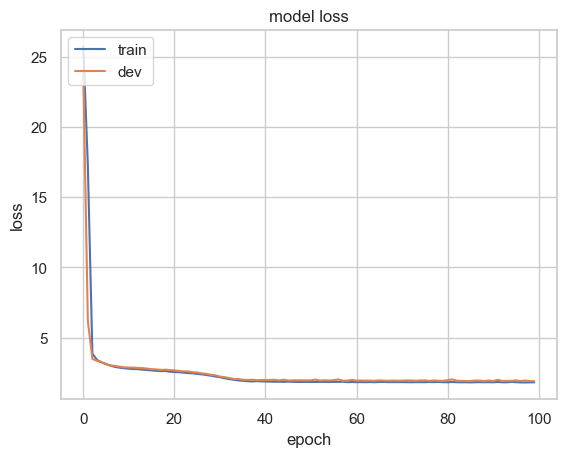

In [32]:
# summarize history loss
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [33]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(estimator, random_state=1).fit(X_train,y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
7.3834 ± 0.1453,Lsub
1.0338 ± 0.0570,asub
0.6254 ± 0.0402,bsub
0.2229 ± 0.0080,Lcer
0.1467 ± 0.0093,bcer
0.1044 ± 0.0033,acer
0.0945 ± 0.0085,Thickness


In [58]:
# define the model
model = Sequential()
model.add(Dense(units=20, input_dim=7, kernel_initializer='normal', activation='relu'))
model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='linear'))
model.compile(loss='mae', optimizer='adam')

In [39]:
#get model
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer='adam')
    return model

In [40]:
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = []
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=100, batch_size = 20)
        # evaluate model on test set
        mae = model.evaluate(X_test, y_test, verbose=0)
        # store result
        print('>%.3f' % mae)
        results.append(mae)
    return results

In [41]:
# evaluate model
results = evaluate_model(X, y)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(results), std(results)))

>1.637
>1.439
>1.483
>1.075
>1.213
>1.344
>2.222
>1.241
>1.175
>21.404
>1.492
>1.217
>1.355
>2.531
>1.234
>1.540
>1.518
>1.663
>1.471
>2.552
>1.060
>1.580
>21.113
>21.314
>1.167
>1.578
>1.390
>0.789
>1.358
>1.504
MAE: 3.455 (5.953)


In [65]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

pred = pd.DataFrame(model.predict(X_test_scaled), columns=['Lpred','apred','bpred'])

14/14 [==============================] - 0s 679us/step


In [42]:
import gradio as gr

def greet(Thickness, Lsub, asub, bsub, Lcer, acer, bcer):
    list = [Thickness, Lsub, asub, bsub, Lcer, acer, bcer]
    df2 = pd.DataFrame(list).T
    output = model.predict(df2)
    Lf = pd.DataFrame(output, columns = ['L', 'a', 'b'])._get_value(0, 'L')
    af = pd.DataFrame(output, columns = ['L', 'a', 'b'])._get_value(0, 'a')
    bf = pd.DataFrame(output, columns = ['L', 'a', 'b'])._get_value(0, 'b')
    
    Lf = np.clip(Lf, np.min([Lcer,Lsub]), np.max([Lcer,Lsub]))
    af = np.clip(af, np.min([acer,asub]), np.max([acer,asub]))
    bf = np.clip(bf, np.min([bcer,bsub]), np.max([bcer,bsub]))
    
    return Lf, af, bf

demo = gr.Interface(fn=greet, inputs=[gr.Slider(0, 5, 0.1),
                                      gr.Slider(0, 100, 1),
                                      gr.Slider(-10, 10, 0.2),
                                      gr.Slider(-20, 20, 0.2),
                                      gr.Slider(0, 100, 1),
                                      gr.Slider(-10, 10, 0.2),
                                      gr.Slider(-20, 20, 0.2)], outputs=["number","number", "number"])